In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [10]:
df = pd.read_csv("ecg_final.txt", sep='  ', header=None)
df.shape

/var/folders/8p/ynsnf9_d5tx923362twrj9rw0000gn/T/ipykernel_4397/2285034167.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("ecg_final.txt", sep='  ', header=None)


(5000, 141)

In [14]:
df.iloc[0]

0      1.000000
1     -0.112522
2     -2.827204
3     -3.773897
4     -4.349751
         ...   
136    0.257740
137    0.228077
138    0.123431
139    0.925286
140    0.193137
Name: 0, Length: 141, dtype: float64

In [15]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=111)
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

In [17]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

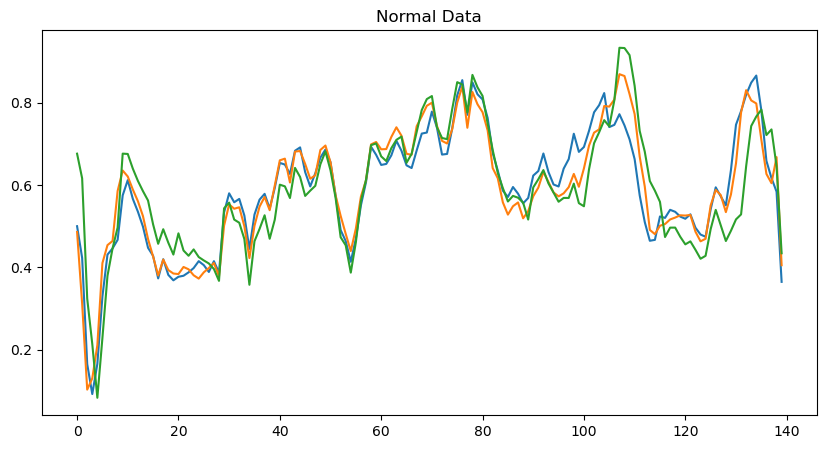

In [18]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data")
plt.show()

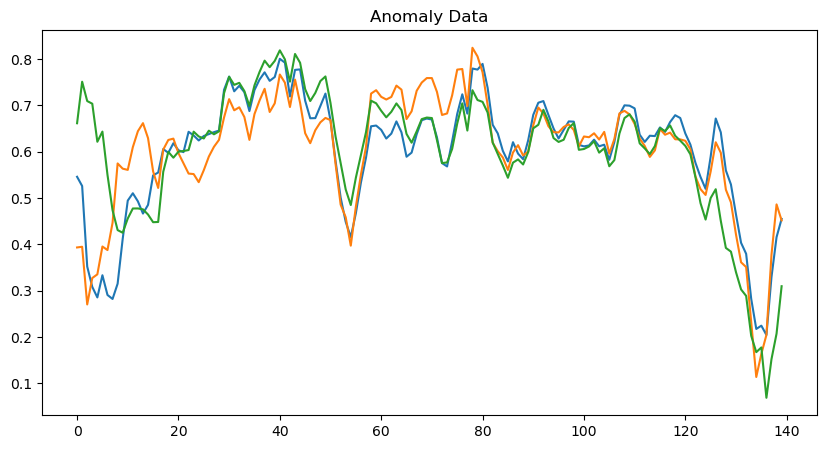

In [19]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data")
plt.show()

In [20]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [21]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,#for time series have to set to false because the order matters
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 0s 4ms/step - loss: 0.1305 - val_loss: 0.1169
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0832
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0769
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0486 - val_loss: 0.0758
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0481 - val_loss: 0.0756
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0752
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0745
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0740
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0737
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0733
Epoch 11/50
20/20 [

In [22]:
encoder_out = model.encoder(normal_test_data).numpy() 
decoder_out = model.decoder(encoder_out).numpy()

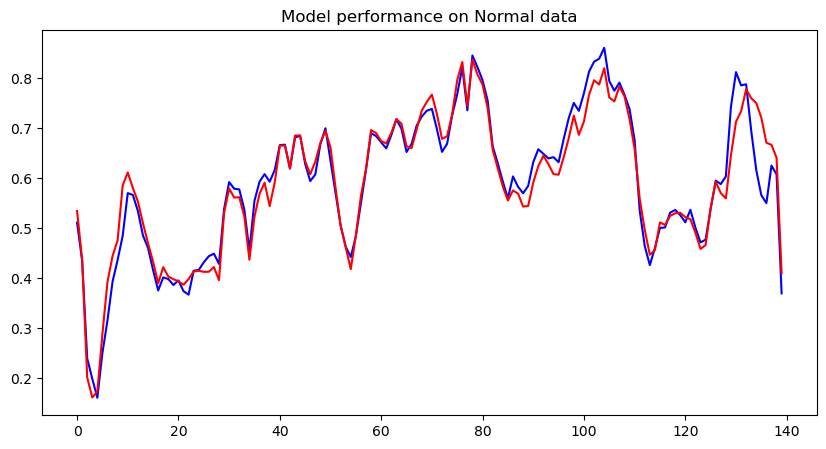

In [23]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data")
plt.show()

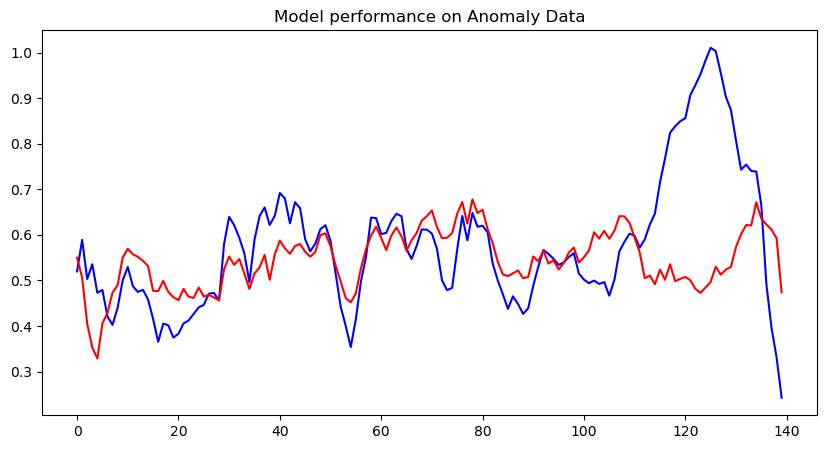

In [24]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data")
plt.show()

18/18 [==============================] - 0s 321us/step


(array([ 4.,  8., 23., 32., 46., 38., 38., 31., 45., 41., 21., 22., 19.,
        23., 25., 17., 13., 16.,  8.,  7.,  5., 17.,  5.,  7.,  5.,  5.,
         5.,  5.,  5.,  5.,  2.,  0.,  1.,  2.,  1.,  3.,  1.,  1.,  4.,
         2.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01233591, 0.01414664, 0.01595736, 0.01776808, 0.01957881,
        0.02138953, 0.02320025, 0.02501098, 0.0268217 , 0.02863242,
        0.03044315, 0.03225387, 0.03406459, 0.03587532, 0.03768604,
        0.03949676, 0.04130748, 0.04311821, 0.04492893, 0.04673965,
        0.04855038, 0.0503611 , 0.05217182, 0.05398255, 0.05579327,
        0.05760399, 0.05941472, 0.06122544, 0.06303616, 0.06484689,
        0.06665761, 0.06846833, 0.07027906, 0.07208978, 0.0739005 ,
        0.07571123, 0.07752195, 0.07933267, 0.0811434 , 0.08295412,
        0.08476484, 0.08657557, 0.08838629, 0.09019701, 0.09200773,
        0.09381846, 0.09562918, 0.0974399 , 0.09925063, 0.10106135,
        0.10287207]),
 <BarContainer

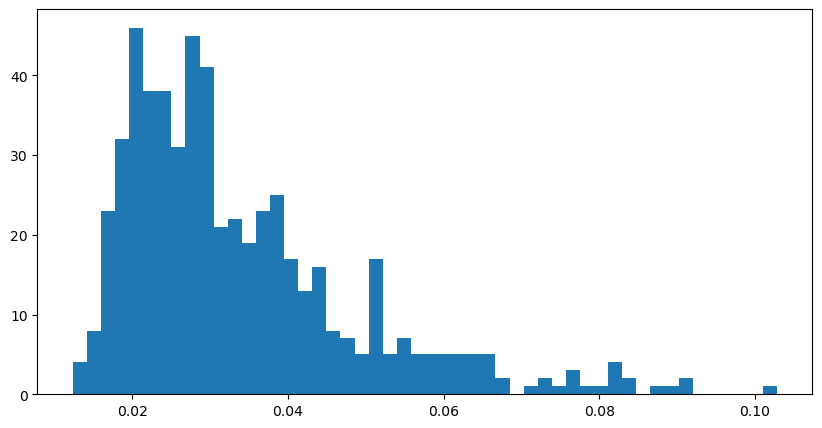

In [25]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50)

14/14 [==============================] - 0s 590us/step


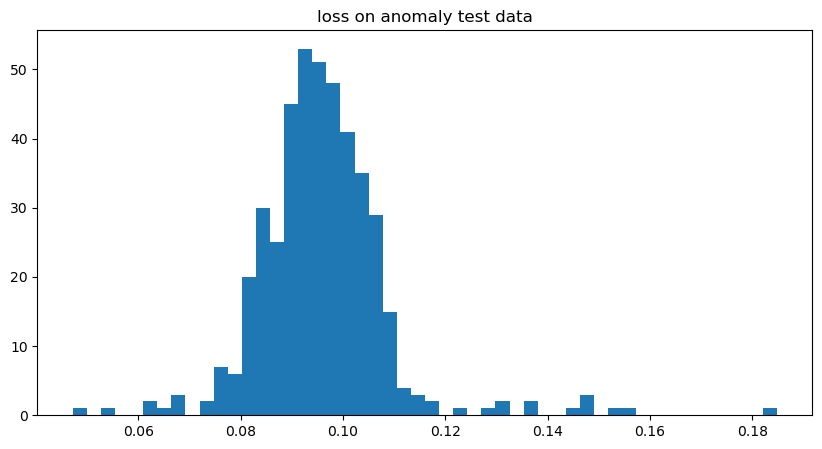

In [26]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data")
plt.show()

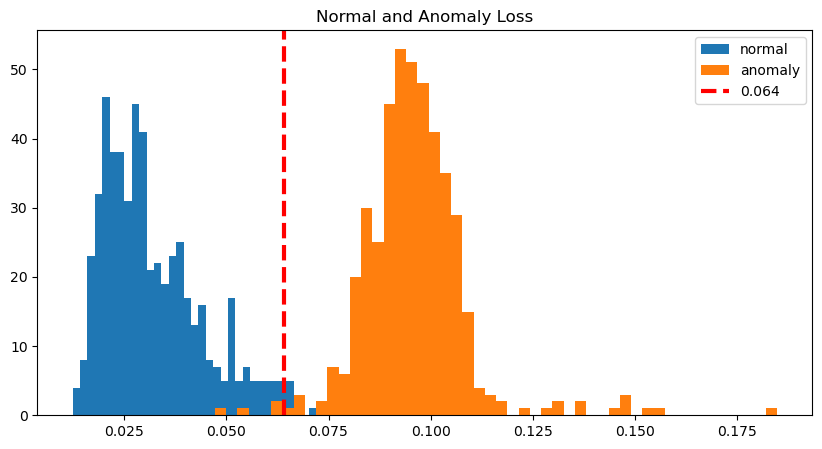

In [27]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Our dataset provides the targets as the first column, which we won't use for training in this case.
        # We only use the features for the autoencoder.
        feature = self.features[idx]
        target = self.targets[idx]  # In case you need the target for something else
        return feature

# Load the data
file_path = 'ECG5000_TRAIN.txt'
data = pd.read_csv(file_path, header=None, sep='\s+')

# Assuming that the first column is the label and the rest are the features
X = data.iloc[:, 1:61].values.astype('float32')
y = data.iloc[:, 0].values.astype('float32')

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create dataset objects
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

# Create DataLoader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=10, shuffle=False)

# Now you can use train_loader in your training loop


In [36]:
X_train.shape

(400, 60)

In [37]:

import torch.nn as nn
import torch.optim as optim
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Tanh(),
            nn.Linear(25, output_dim)
        )

    def forward(self, x):
        return self.network(x)

class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 25),
            nn.Tanh(),
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.network(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Linear(25, 1)  # Last layer with linear activation
        )

    def forward(self, x):
        return self.network(x)

# Now, let's define the hyperparameters and initialize the models, optimizers, and training loop.
# These parameters will be set based on whether we're working with synthetic data (m=20) or real data (m=100).

# Hyperparameters for synthetic case
m = 20  # Change to m = 100 for real data cases
mu = 0.1 if m == 20 else 0.01  # Tuning parameter
lambda_gp = 5 if m == 20 else 3  # Lambda for gradient penalty
lr = 0.0002 if m == 20 else 0.001  # Learning rate
betas = (0.9, 0.999)  # Beta hyperparameters for Adam optimizer

# Model input dimensionality
input_dim = 3 * m
output_dim = m

# Initialize the models
encoder = Encoder(input_dim, output_dim)
decoder = Decoder(output_dim, input_dim)
discriminator = Discriminator(output_dim)

# Optimizers
optimizer_G = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# Now you would continue with the training loop as previously outlined, incorporating these model architectures.
# The training loop would include the training of the encoder, decoder (generator in this context), and discriminator.

# Note: The training loop, DataLoader, and the rest of the training infrastructure remain the same.
# Make sure to define your DataLoader 'train_loader' with your dataset before running the training loop.



In [38]:
# This function will calculate the gradient penalty to enforce the Lipschitz constraint for the Wasserstein GAN.
def compute_gradient_penalty(D, real_samples, fake_samples):
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1), device=real_samples.device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [40]:
num_epochs = 5
batch_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#This line checks if CUDA (the driver and software layer that enables use of NVIDIA GPUs) is available. 
#If a GPU with CUDA is available, it sets device to "cuda", otherwise, it falls back to using the CPU.
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        # Assuming data is just features with no labels
        data = data.to(device)  # If using GPU
        
        # Reset gradients for both optimizers
        optimizer_G.zero_grad()
        optimizer_D.zero_grad()
        
        # Forward pass through the encoder and decoder
        encoded_data = encoder(data)
        decoded_data = decoder(encoded_data)
        
        # Compute reconstruction loss
        reconstruction_loss = torch.mean((data - decoded_data) ** 2)
        
        # Compute discriminator loss for real and fake data
        real_data = torch.randn(batch_size, m, device=device)  # You need to define m
        fake_data = encoded_data.detach()  # Detach so gradients are not calculated for encoder during discriminator update
        real_scores = discriminator(real_data)
        fake_scores = discriminator(fake_data)
        d_loss = -(torch.mean(real_scores) - torch.mean(fake_scores))
        
        # Add gradient penalty to the discriminator loss
        gradient_penalty = compute_gradient_penalty(discriminator, real_data, fake_data)
        d_loss += lambda_gp * gradient_penalty
        
        # Update discriminator
        d_loss.backward()
        optimizer_D.step()
        
        # Update generator (encoder and decoder)
        g_loss = reconstruction_loss - torch.mean(discriminator(encoded_data))  # Wasserstein GAN Generator loss
        g_loss.backward()
        optimizer_G.step()
        
        if i % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Batch {i}/{len(train_loader)}, D loss: {d_loss.item()}, G loss: {g_loss.item()}')


Epoch 0/5, Batch 0/40, D loss: 3.7138566970825195, G loss: 0.7776955366134644
Epoch 1/5, Batch 0/40, D loss: 0.6179447174072266, G loss: 0.5250301957130432
Epoch 2/5, Batch 0/40, D loss: 0.7225480079650879, G loss: 0.39434778690338135
Epoch 3/5, Batch 0/40, D loss: 0.8836596012115479, G loss: 0.7544366121292114
Epoch 4/5, Batch 0/40, D loss: 1.1928868293762207, G loss: -0.3877718448638916
